# Parsing 1000Z Rigol Waveforms

**Scott Prahl**

**Mar 2020**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

try:
    import RigolWFM.wfm as rigol

except:
    print("***** You need to install the module to read Rigol files first *****")
    print("***** Execute the following line in a new cell, then retry     *****")
    print()
    print("!{sys.executable} -m pip install RigolWFM")
    
def lsf_with_errors(x,y):
    '''
    Find the least squares slope and intercept
    Args:
        x: array of x values
        y: array of y values
    Returns
        m: slope of fitted line
        b: intercept of fitted line
        sigma_m: estimated error in slope
        sigma_b: estimated error in intercept
    '''
    p,V = np.polyfit(x, y, 1, cov=True)
    m = p[0]
    b = p[1]
    sigma_m = np.sqrt(V[0][0])
    sigma_b = np.sqrt(V[1][1])
    return m, b, sigma_m, sigma_b

repo = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/"



## Yet another 1000Z file

The goal of this notebook is to figure out conversion of raw data to voltage on the Rigol 1000Z oscilloscope `.wfm` files and also validate the conversion against `.csv` files.  

**Alas, there is still something screwy about the conversion of raw bytes to volts.  The conversion is often close, but sometimes the offset is messed up.**

<img src='https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-B.png' width="100%">

In [2]:
# raw=true is needed because this is a binary file
wfm_url = repo + "DS1054Z-B.wfm" + "?raw=true"  

w = rigol.Wfm.from_url(wfm_url, '1000Z')

description = w.describe()
print(description)

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-B.wfm?raw=true'
    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = unknown
        Filename     = DS1054Z-B.wfm
        Channels     = [1, 2, 3, 4]

     Channel 1:
         Coupling =       DC
            Scale =     2.00  V/div
           Offset =     2.80  V
            Probe =      10X

        Time Base =  100.000 µs/div
           Offset =    1.000 µs
            Delta =    4.000 ns/point
           Points =   300128

         Count    = [        1,        2,        3  ...    300127,   300128]
           Raw    = [      186,      185,      186  ...       174,      172]
           Times  = [-599.256 µs,-599.252 µs,-599.248 µs  ... 601.252 µs,601.256 µs]
           Volts  = [  3.10  V,  3.00  V,  3.10  V  ...   1.90  V,  1.70  V]

     Channel 2:
         Coupling =       DC
            Scale =     2.00  V/div
           Offset =  

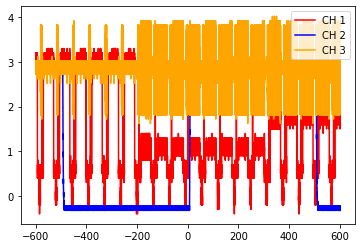

In [3]:
clr = ['red','blue','orange','magenta']

# only plot the first three channels because the third is much
# higher frequency and covers everything
for i,ch in enumerate(w.channels):
    if i==3:
        break
    plt.plot(ch.times*1e6, ch.volts, color=clr[i], label=ch.name)

plt.legend(loc='upper right')
#plt.xlim(-6,6)
plt.show()

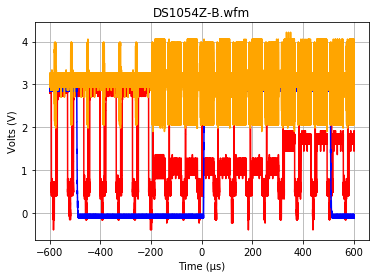

In [4]:
csv_filename = repo + "DS1054Z-B.csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2).T

# construct times for each point using values from the second line of the .csv file
t_incr = 4.000000e-9   # seconds/point
t_start = -300000/2 * t_incr    # seconds/point
t_start = -5.99e-4
csv_times = csv_data[0] * t_incr + t_start   # seconds

plt.plot(csv_times*1e6, csv_data[1],color='red')
plt.plot(csv_times*1e6, csv_data[2],color='blue')
plt.plot(csv_times*1e6, csv_data[3],color='orange')
#plt.plot(csv_times*1e6, csv_data[4],color='magenta')


plt.xlabel("Time (µs)")
plt.ylabel("Volts (V)")
plt.grid(True)
#plt.xlim(-2,22)
plt.title("DS1054Z-B.wfm")
#plt.xticks(np.linspace(-2,22,13))
#plt.xlim(-1,1)


plt.show()

slope = 0.98837 ± 0.00007 V/bit
intercept = -0.02059 ± 0.00018 V
scale  = -0.100
v/div  = 2.000
offset = 2.800


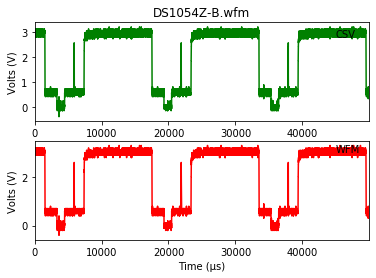

slope = 0.95940 ± 0.00005 V/bit
intercept = 0.18263 ± 0.00011 V
scale  = -0.100
v/div  = 2.000
offset = -1.480


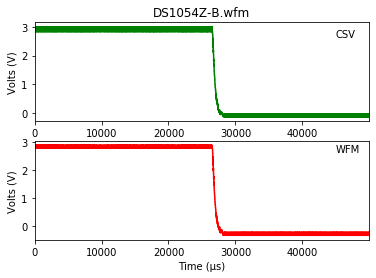

slope = 0.97947 ± 0.00039 V/bit
intercept = 0.24906 ± 0.00114 V
scale  = -0.100
v/div  = 2.000
offset = -7.020


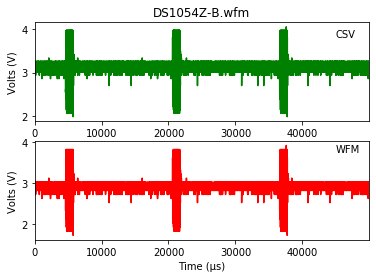

slope = 0.96225 ± 0.00005 V/bit
intercept = 0.38776 ± 0.00010 V
scale  = -0.100
v/div  = 2.000
offset = -9.540


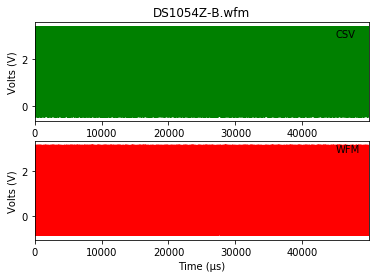

In [5]:
def compare(w, csv_data, chno):
    n=50000
    s=43
    e=n+s
    ch = w.channels[chno-1]
    x = (127.0-ch.raw[s:e])*ch.volt_scale-ch.volt_offset

    y = csv_data[chno][:n]
    t = csv_data[0][:n]
    m, b, sigma_m, sigma_b = lsf_with_errors(x,y)

    print("slope = %.5f ± %.5f V/bit" % (m, sigma_m))
    print("intercept = %.5f ± %.5f V" % (b, sigma_b))

    print("scale  = %.3f" % ch.volt_scale)
    print("v/div  = %.3f" % ch.volt_per_division)
    print("offset = %.3f" % ch.volt_offset)

    fig, ax = plt.subplots()
    plt.subplot(211)
    plt.plot(t,y, color='green')
    plt.title(w.basename)
    plt.ylabel("Volts (V)")
    plt.text(0.9, 0.97, 'CSV', ha='left', va='top', transform=ax.transAxes)
    plt.xlim(t[0],t[-1])


    plt.subplot(212)
    ch = w.channels[0]
    plt.plot(t,x, color='red')
    plt.xlabel("Time (µs)")
    plt.ylabel("Volts (V)")
    #plt.xlim(-0.6,0.6)
    plt.text(0.9, 0.44, 'WFM', ha='left', va='top', transform=ax.transAxes)
    plt.xlim(t[0],t[-1])


    plt.show()
    
for i in [1,2,3,4]:
    compare(w,csv_data,i)